Пока это скорее заглушка, ДЗ только начато

## Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.

In [67]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


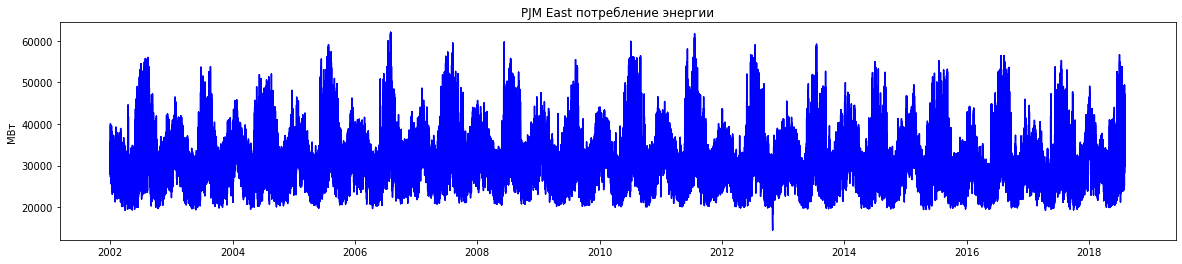

In [3]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [90]:
data_w = data.copy().resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [91]:
data_w.drop('hour', axis=1,inplace=True)
data_w.drop('dayofweek', axis=1,inplace=True)
data_w.drop('is_holiday', axis=1,inplace=True)
data_w.drop('is_prev_holiday', axis=1,inplace=True)
data_w.drop('is_next_holiday', axis=1,inplace=True)
#Поскольку в годовом развороте ряда тренда нет (временные ряды 2 и 3), 
#то и признак 'year' можно исключить.
data_w.drop('year', axis=1,inplace=True)
data_w.head()

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear
Date,,,,,,
2002-01-06,32392.160839,1.000000,3.517483,1.0,3.517483,1.0
2002-01-13,31487.386905,1.000000,10.000000,1.0,10.000000,2.0
2002-01-20,31452.880952,1.000000,17.000000,1.0,17.000000,3.0
2002-01-27,30141.529762,1.000000,24.000000,1.0,24.000000,4.0
2002-02-03,29196.488095,1.428571,17.714286,1.0,31.000000,5.0


Можно построить интегральный признак используя кластер-анализ или частичную классификацию. Начнем с признака по кластер-анализу. Воспользуемся методом kmeans, если можем предположить сколько будет кластеров, или DBSCAN, который не требует знания реального числа кластеров. 

In [92]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import seaborn as sns

scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_w.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

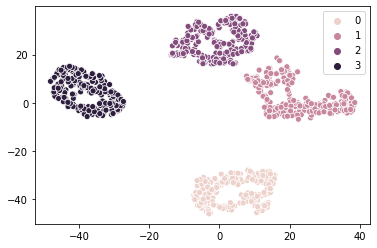

In [93]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

In [94]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  1
Число кластеров в календаре:  4


Принадлежность кластерам можно использовать в качестве нового признака и проверить качество обработки модели с новой координатой. В данном конкретном примере кластеризация без масштабирования, но с понижением размерности выглядит очень обосновано. Берем этот вариант за основу и добавим признак к общему описанию задачи. 

In [95]:
data_w['claster_feat'] = X_clast
data_w.iloc[np.where(data_w['claster_feat']==0)[0]].iloc[:10,:]

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,claster_feat
Date,,,,,,,
2002-01-06,32392.160839,1.000000,3.517483,1.0,3.517483,1.0,0
2002-01-13,31487.386905,1.000000,10.000000,1.0,10.000000,2.0,0
2002-01-20,31452.880952,1.000000,17.000000,1.0,17.000000,3.0,0
2002-01-27,30141.529762,1.000000,24.000000,1.0,24.000000,4.0,0
2002-02-03,29196.488095,1.428571,17.714286,1.0,31.000000,5.0,0
2002-02-10,31150.517857,2.000000,7.000000,1.0,38.000000,6.0,0
2002-02-17,30616.565476,2.000000,14.000000,1.0,45.000000,7.0,0
2002-02-24,29144.130952,2.000000,21.000000,1.0,52.000000,8.0,0
2002-03-03,29869.011905,2.428571,16.000000,1.0,59.000000,9.0,0


In [96]:
data_w['claster_feat'] = X_clast
data_w.iloc[np.where(data_w['claster_feat']==2)[0]].iloc[:10,:].count()

PJME_MW         10
month           10
dayofmonth      10
quarter         10
dayofyear       10
weekofyear      10
claster_feat    10
dtype: int64

Похоже новый сильно связан с кварталом и нет смысла в его дублировании.
Простая, хотя и линейная модель, это PCA - метод главных компонент. Поскольку наши координаты календаря вполне связаны, то можно проверить и такой путь объединения признаков. Добавим признак на основе компонетного анализа. Построим 2 компоненты по признакам из календаря , без значений ряда и допишем их в общую таблицу.

In [97]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(866, 2)

In [98]:
data_w['pca1']=Xpca[:,0]
data_w['pca2']=Xpca[:,1]

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.
можно добавить все, что можем придумать. Например, логарифм признака, частные признаков , частные логарифмов и т.д

In [99]:
first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

In [100]:
first_diff_w =(first_diff) / data_w.iloc[1:,0].values
data_w['diff1_d'] = 0
data_w['diff1_d'] =  data_w['diff1_d'].astype('float') 
data_w['diff1_d'].values[1:] = np.array(first_diff_w).astype('float32')

In [101]:
first_diff_l =np.log(data_w.iloc[1:,0].values) 
data_w['diff1_l'] = 0
data_w['diff1_l'] =  data_w['diff1_l'].astype('float') 
data_w['diff1_l'].values[1:] = first_diff_l

In [102]:
#Добавим скользящее среднее по всей модели с глубиной 4 и 13 недели. 
data_w['d_w4']=data_w['PJME_MW'].rolling(window=4).mean()
data_w['d_w13']=data_w['PJME_MW'].rolling(window=13).mean()

In [103]:
#А теперь добавим еще и экспонентциальную среднюю. 
#Медленную, т.к. интересная информация лежит на уровне сезонных колебаний цены.
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)

In [104]:
data_w.iloc[10:15,:]

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,claster_feat,pca1,pca2,diff1,diff1_d,diff1_l,d_w4,d_w13,exp_0_05
Date,,,,,,,,,,,,,,,
2002-03-17,28672.779762,3.0,14.000000,1.0,73.000000,11.0,0,-1.973262,-0.181368,-768.130981,-0.026790,10.263704,29281.708333,NaN,31436.852496
2002-03-24,29927.488095,3.0,21.000000,1.0,80.000000,12.0,0,-1.900509,0.843948,1254.708374,0.041925,10.306533,29477.547619,NaN,31361.384276
2002-03-31,27595.869048,3.0,28.000000,1.0,87.000000,13.0,0,-1.827755,1.869264,-2331.619141,-0.084492,10.225421,28909.261905,30083.670797,31173.108514
2002-04-07,28308.778443,4.0,3.982036,2.0,93.982036,14.0,1,-1.209696,-1.689802,712.909424,0.025183,10.250927,28626.228837,29769.564459,31029.892011
2002-04-14,27182.482143,4.0,11.000000,2.0,101.000000,15.0,1,-1.136756,-0.661854,-1126.296265,-0.041435,10.210328,28253.654432,29438.417939,30837.521517


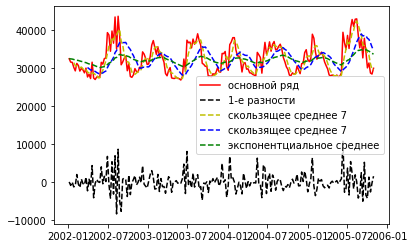

In [105]:
N100=200
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(data_w.index[:N100],data_w['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_w.index[:N100],data_w['d_w4'][:N100],'--y',label ='скользящее среднее 7')
plt.plot(data_w.index[:N100],data_w['d_w13'][:N100],'--b',label ='скользящее среднее 7')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()

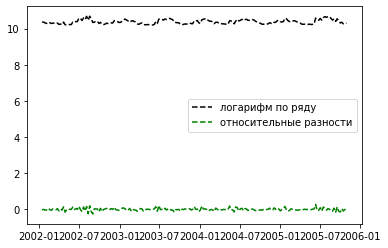

In [106]:
N100=200
plt.plot(data_w.index[1:N100],data_w['diff1_l'][1:N100],'--k',label ='логарифм по ряду')
plt.plot(data_w.index[1:N100],data_w['diff1_d'][1:N100],'--g',label ='относительные разности')
plt.legend()
plt.show()

Для определения разумных интервалов имеет смысл вспомнить результаты анализа ряда в статистических моделях. Период сезонных колебаний 52 недельный цикл. Это позволит не строить все возможные сочетания параметров модели, а сократить их число до относительно небольшого подмножества. Посмотрим на примере экспоненциальных средних в диапазоне alpha = [0.3, 0.8] 

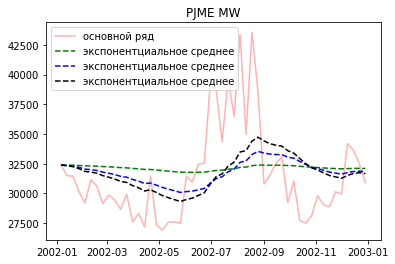

In [107]:
data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_04'] = exponential_smoothing(data_w['PJME_MW'], 0.04)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.05)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)

N100=52
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(data_w.index[:N100],data_w['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

Добавим истории длиной p в признаках автокорреляции, аналогично добавляем первые разности на глубину p

In [108]:
p = 13
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]
for i in range(p):
    data_w['d'+str(p-i)]=0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

In [109]:
data_w.tail(10)

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,claster_feat,pca1,pca2,diff1,...,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-03,30945.601190,5.428571,17.714286,2.000000,151.000000,22.0,1,-0.579480,0.314349,563.208313,...,-641,-2980,910,-1162,42,-2200,2588,-1531,1238,2528
2018-06-10,28615.154762,6.000000,7.000000,2.000000,158.000000,23.0,1,-0.493596,-1.257823,-2330.446533,...,-2980,910,-1162,42,-2200,2588,-1531,1238,2528,563
2018-06-17,30316.940476,6.000000,14.000000,2.000000,165.000000,24.0,1,-0.420843,-0.232507,1701.785767,...,910,-1162,42,-2200,2588,-1531,1238,2528,563,-2330
2018-06-24,34711.648810,6.000000,21.000000,2.000000,172.000000,25.0,1,-0.348090,0.792809,4394.708496,...,-1162,42,-2200,2588,-1531,1238,2528,563,-2330,1701
2018-07-01,35911.839286,6.142857,23.714286,2.142857,179.000000,26.0,1,-0.196725,1.184480,1200.190430,...,42,-2200,2588,-1531,1238,2528,563,-2330,1701,4394
2018-07-08,38459.982143,7.000000,5.000000,3.000000,186.000000,27.0,2,0.347692,-1.592072,2548.142822,...,-2200,2588,-1531,1238,2528,563,-2330,1701,4394,1200
2018-07-15,36420.035714,7.000000,12.000000,3.000000,193.000000,28.0,2,0.420446,-0.566756,-2039.946411,...,2588,-1531,1238,2528,563,-2330,1701,4394,1200,2548
2018-07-22,35612.095238,7.000000,19.000000,3.000000,200.000000,29.0,2,0.493199,0.458560,-807.940491,...,-1531,1238,2528,563,-2330,1701,4394,1200,2548,-2039
2018-07-29,36581.821429,7.000000,26.000000,3.000000,207.000000,30.0,2,0.565953,1.483876,969.726196,...,1238,2528,563,-2330,1701,4394,1200,2548,-2039,-807


In [110]:
data_w.fillna(0)
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 46 columns):
PJME_MW         866 non-null float64
month           866 non-null float64
dayofmonth      866 non-null float64
quarter         866 non-null float64
dayofyear       866 non-null float64
weekofyear      866 non-null float64
claster_feat    866 non-null int64
pca1            866 non-null float64
pca2            866 non-null float64
diff1           866 non-null float64
diff1_d         866 non-null float64
diff1_l         866 non-null float64
d_w4            863 non-null float64
d_w13           854 non-null float64
exp_0_05        866 non-null float64
exp_0_01        866 non-null float64
exp_0_03        866 non-null float64
exp_0_04        866 non-null float64
exp_0_06        866 non-null float64
exp_0_08        866 non-null float64
t13             866 non-null int64
t12             866 non-null int64
t11             866 non-null int64
t10             866 n

## Выделение существенных признаков
Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [111]:
scl_target=StandardScaler() 
# p = 7
h=1
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(852, 1)

Входной набор признаков берем из нашей таблицы. Необходимо помнить, что у нас есть интегральные признаки (для календаря), которые связаны с базовыми признаками. Обычно такие признаки рассматривают отдельно. Однако для эксперимента оставим все признаки для процедуры селекции.


In [112]:
scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(852, 46)

Есть признаки хорошие, а есть признаки плохие. Применим механизмы  селекции признаков для нашей модели. 
Рассмотрим механизмы селекции специфичные для регрессий и доступные из scikit-learn. Это два основных способа селекции: 
- построим или применим метрику взвешивающую связь признака и целевого свойства,
- проведем предварительное обучение и проверим влиятельность признаков по результатам такого обучения.

Такое решение задачи селекции признаков поддерживается через SelectKBest (отбираем k лучших признаков), SelectPercentile (отбираем заданный процент признаков) и SelectFromModel, соответственно(https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Посмотрим на результаты оценки нашей системы признаков.

In [113]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=0.97,  I=0
F-test=0.00,  I=1
F-test=0.00,  I=2
F-test=0.00,  I=3
F-test=0.00,  I=4
F-test=0.00,  I=5
F-test=0.00,  I=6
F-test=0.00,  I=7
F-test=0.00,  I=8
F-test=0.02,  I=9
F-test=0.01,  I=10
F-test=1.00,  I=11
F-test=0.58,  I=12
F-test=0.00,  I=13
F-test=0.02,  I=14
F-test=0.01,  I=15
F-test=0.02,  I=16
F-test=0.02,  I=17
F-test=0.03,  I=18
F-test=0.05,  I=19
F-test=0.27,  I=20
F-test=0.29,  I=21
F-test=0.27,  I=22
F-test=0.19,  I=23
F-test=0.12,  I=24
F-test=0.06,  I=25
F-test=0.01,  I=26
F-test=0.00,  I=27
F-test=0.02,  I=28
F-test=0.07,  I=29
F-test=0.15,  I=30
F-test=0.30,  I=31
F-test=0.51,  I=32
F-test=0.00,  I=33
F-test=0.00,  I=34
F-test=0.00,  I=35
F-test=0.01,  I=36
F-test=0.01,  I=37
F-test=0.02,  I=38
F-test=0.03,  I=39
F-test=0.04,  I=40
F-test=0.04,  I=41
F-test=0.04,  I=42
F-test=0.03,  I=43
F-test=0.02,  I=44
F-test=0.02,  I=45


Применим автоматизацию выбора через SelectKBest c выделением  лучших признаков.

In [114]:
sfk =SelectKBest(f_regression, k=6)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(852, 6)

In [115]:
column_names = data_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 'd_w4', 't12', 't2', 't1'], dtype='object')

Лучшее множество признаков отделено в X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [116]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(852, 5)

In [117]:
column_namesp = data_w.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 'd_w4', 't2', 't1'], dtype='object')

Наконец, третий вариант - применим выделение признаков через построение модели. Помним, что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [118]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(852, 5)

In [119]:
#Сравним результаты:
[X_new1[10:15,:], X_new2[10:15,:],X_new3[10:15,:]]

[array([[ 0.0843064 ,  0.14756469, -0.42482516, -0.53728302, -0.16044304,
         -0.28384736],
        [ 0.11010632,  0.1736621 , -0.06839591, -1.1227561 , -0.28225851,
          0.08699725],
        [ 1.78805972,  1.71440918,  0.48089932, -0.94374996,  0.08869086,
          0.11275382],
        [ 1.63030258,  1.58124532,  1.02006521, -1.22644408,  0.11445471,
          1.79068189],
        [ 0.56313881,  0.61891189,  1.15475913, -0.14638182,  1.79285677,
          1.63289164]]),
 array([[ 0.0843064 ,  0.14756469, -0.42482516, -0.16044304, -0.28384736],
        [ 0.11010632,  0.1736621 , -0.06839591, -0.28225851,  0.08699725],
        [ 1.78805972,  1.71440918,  0.48089932,  0.08869086,  0.11275382],
        [ 1.63030258,  1.58124532,  1.02006521,  0.11445471,  1.79068189],
        [ 0.56313881,  0.61891189,  1.15475913,  1.79285677,  1.63289164]]),
 array([[ 0.0843064 , -0.27199626,  0.14756469, -1.12010537, -0.1442655 ],
        [ 0.11010632, -0.22948867,  0.1736621 , -0.94129325, 

In [120]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 11 12 21 31 32]
Номера признаков лучших признаков по процентной форме:  [ 0 11 12 31 32]
Номера признаков для выбора по модели :  [ 0  7 11 22 25]


Очень смущает, что нет признака weekofyear или номера квартала, добавлю weekofyear. Хотя возможно он есть в pca1
(Забегая вперед, он улучшил результат предсказания, было 7,11%)

In [139]:
''' 0- 'PJME_MW'
5- weekofyear
7 -pca1
11 -diff1_l
12 -d_w4

'''
list_par=[0, 5, 7, 11,12,21, 22, 31, 32]
X_new = X[:,list_par]
data_w.columns[list_par]


Index(['PJME_MW', 'weekofyear', 'pca1', 'diff1_l', 'd_w4', 't12', 't11', 't2',
       't1'],
      dtype='object')

## Разделение данных на тестовые и тренировочные 

In [140]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

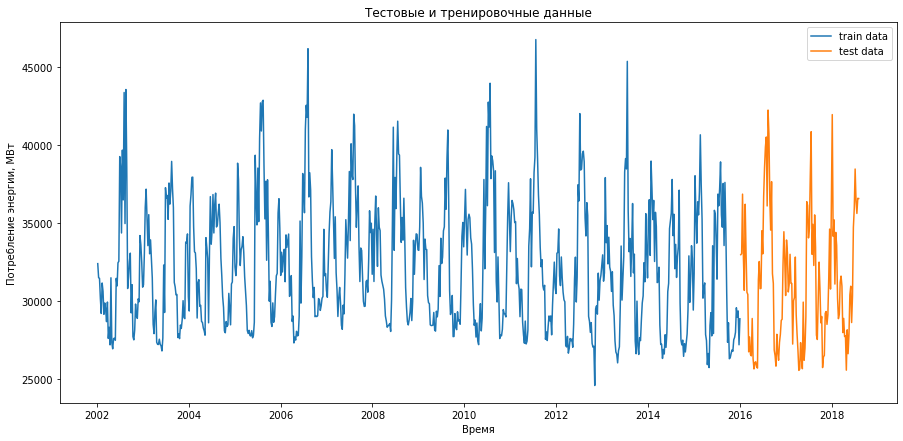

In [141]:
train, test = split_data( data_w, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [124]:
X_new

array([[-0.94984308, -0.83670123, -0.97322541, ..., -0.22799947,
        -0.54089751, -1.12556209],
       [-1.23149101, -0.76978398, -1.30694268, ..., -0.36187355,
        -1.12421102, -0.94726661],
       [-0.15570743, -0.70286673, -0.09927191, ..., -0.73090472,
        -0.94586516, -1.22883844],
       ...,
       [ 1.07850312,  0.10014025,  1.09772806, ..., -1.05430839,
         0.95590695,  1.59113098],
       [ 0.87646502,  0.1670575 ,  0.91332748, ..., -0.42053747,
         1.59324949,  1.0812509 ],
       [ 1.11896016,  0.23397474,  1.13416131, ..., -0.27939308,
         1.08322537,  0.87919936]])

In [142]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

# Строим Модель
При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении именно такой формы предсказания. 

In [143]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_g.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [144]:
X_test.shape

(121, 9)

In [42]:
y_test_pred_g = model_g.predict(X_test)

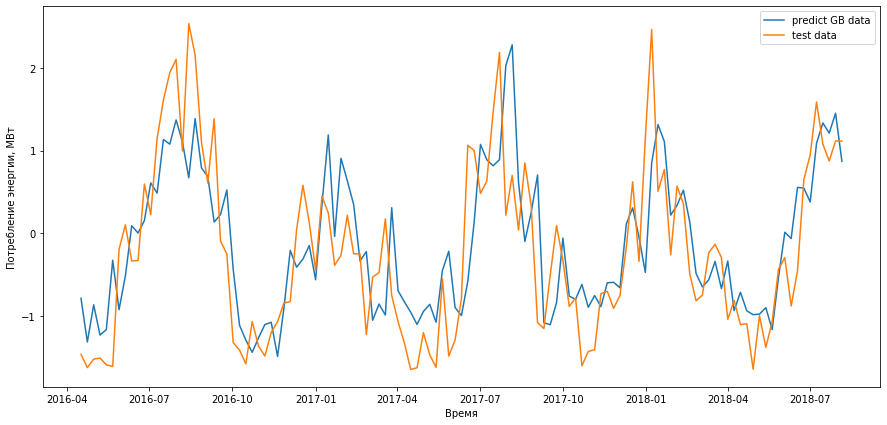

In [145]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [146]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.4698140424799176 
ошибка mae  :   0.5409485041899582 
оценка R2 :   0.564232864880414


In [147]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.8846880957190475 %


Ошибка неплоха, но мы имеем дело с маленьким горизонтом прогноза и есть куда улучшать. Построим более точную модель с использованием поиска моделей. Воспользуемся методом поиска 

In [148]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.697 (std: 0.058)
Parameters: {'n_estimators': 500, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.692 (std: 0.064)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.690 (std: 0.066)
Parameters: {'n_estimators': 100, 'max_depth': 3}



In [152]:
model_g_best = GradientBoostingRegressor(max_depth=1,  n_estimators=300)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.553675907103878 %


In [49]:
import pickle
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))

Качество решения задачи по MAPE стала хуже. Однако и усилий приложено немного.

In [50]:
X_test_200 = X_test.copy()
X_test_200[0]

array([-0.80833689, -0.83670123, -0.81053707, -1.31927054,  0.24326407,
        1.20069026,  1.03828887, -1.37959827, -1.40438322])

## Использование модели для предсказания n*h моментов времени
Мы построили короткий прогноз, но его можно продолжить на следующие точки ряда. Для этого будем использовать результаты прогноза для следующего шага.  Необходимо заменять X_test[t+i, 0] = y_test[t+i-1] и продолжить моделирование в новом состоянии. Сделаем прогноз на 4ую неделю.

In [153]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 46 columns):
PJME_MW         866 non-null float64
month           866 non-null float64
dayofmonth      866 non-null float64
quarter         866 non-null float64
dayofyear       866 non-null float64
weekofyear      866 non-null float64
claster_feat    866 non-null int64
pca1            866 non-null float64
pca2            866 non-null float64
diff1           866 non-null float64
diff1_d         866 non-null float64
diff1_l         866 non-null float64
d_w4            863 non-null float64
d_w13           854 non-null float64
exp_0_05        866 non-null float64
exp_0_01        866 non-null float64
exp_0_03        866 non-null float64
exp_0_04        866 non-null float64
exp_0_06        866 non-null float64
exp_0_08        866 non-null float64
t13             866 non-null int64
t12             866 non-null int64
t11             866 non-null int64
t10             866 n

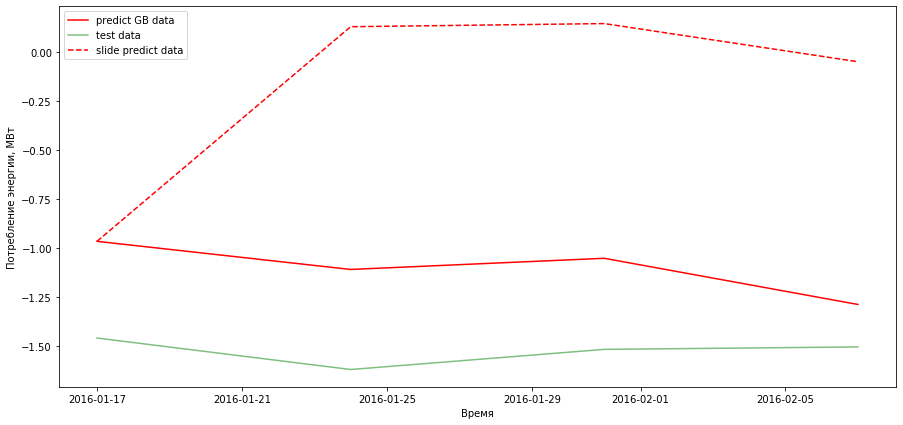

In [154]:
#'PJME_MW', 'weekofyear', 'pca1', 'diff1_l', 'd_w4', 't12', 't11', 't2', 't1']
X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()
N10 = 4
for i in range(N10):   
    
    y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,9)))
    #Восстанавливаем не масштабированное значение ряда
    y_i = scl_target.inverse_transform(y_test_100[i:i+1])
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0]/scl_x.scale_[0])
    #X_test_100[i+1,0] = y_test_100[i]
    #X_test_100[i+1,6] = X_test_100[i+1,0]*(1-0.08)+ 0.08 * X_test_100[i,6] 
    #X_test_100[i+1,5] = X_test_100[i+1,0]*(1-0.07)+ 0.07 * X_test_100[i,5] 
    #Строим d_w4 - признак с индексом 4
    if i>p:
        X_test_100[i+1,4] = np.mean(X_test_100[i+1-p:i+1,0]) 
    #Строим diff1_l - признак с индексом 3
    #строим логарифм по значению ряда и скалируем признак по схеме 11го признака из основного списка
    xy_i = (np.log((y_i))-scl_x.mean_[11])*scl_x.scale_[11]
    #новое значение для 3
    X_test_100[i+1,3] = xy_i 
    #X_test_100[i+1,3] = 0 #np.log( scl_target.inverse_transform(y_test_100[i:i+1]))
    
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')

plt.legend()
plt.show()  

In [155]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[:N10]),y_pred = scl_target.inverse_transform( y_test_100[:N10]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   20.663941223404212 %
